Shor's algorithm

Here we implement Shor's algorithm using the IPE algorithm which lets us use only n+1 qubits w/ $n = log_2 N$ for finding the period of $y : a^x mod N$
As such we use a semi-classical implementation of the QFT using one qubit instead of 2n
This lets us, among other things, choose higher Ns to experiment with on the actual quantum computers
It also reduces the potential errors
We will also implement error correction algorithms thereafter

In [ ]:
from qiskit import *
import numpy as np
import pandas as pd
from math import ceil, gcd, floor
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
import matplotlib.pyplot as plt
from fractions import Fraction
from sympy import isprime
from random import randint

The trickiest part of the algorithm is actually implementing modular multiplication in the general case, so for now we will stick to a basic particular example, which is multiplication modulo 15

In [ ]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [ ]:
def shor_15(a, precision):
    #ideally here we should test if N is of the form a^x aswell since it is less computationally demanding.
    m = 4
    Shor = QuantumCircuit(m+1, precision)
    Shor.x(m)
    for i in range(precision) : 
        if i != 0:
            Shor.reset(0)
        Shor.h(0)
        Shor.append(c_amod15(a, 2**(precision-i-1)), range(m+1))
        if i != 0:
            Shor.p(-np.pi/2,0).c_if(i-1, 1)
        Shor.h(0)
        Shor.measure(0, i)
    return Shor
shor_15(7,8).draw()

Let's now run this code on a simulation (It is basically impossible to run it on actual quantum computers because IBM's hardware doesn't currently support classical boolean functions, and without them, we need at least 2n+3 qubits to run it, which is unfeasible given that we only have 5 qubits at our disposal)

In [ ]:
N = 15
a = 7
precision = 8
sim = Aer.get_backend('aer_simulator')
t_shor = transpile(shor_15(a, precision), sim)
qobj = assemble(t_shor)
results = sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

Let's compare this with the traditional QFT Shor to see the noise gain on a noisy simulation

In [ ]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)

def cU_multi(k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    return cU_multi

def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit
t = precision

shor_Orig = QuantumCircuit(t+m, t)
shor_Orig.h(range(t))

shor_Orig.x(t)
for idx in range(t):
    shor_Orig.append(cU_multi(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_Orig.append(qft_dag, range(t))
shor_Orig.measure(range(t), range(t))
shor_Orig.draw()

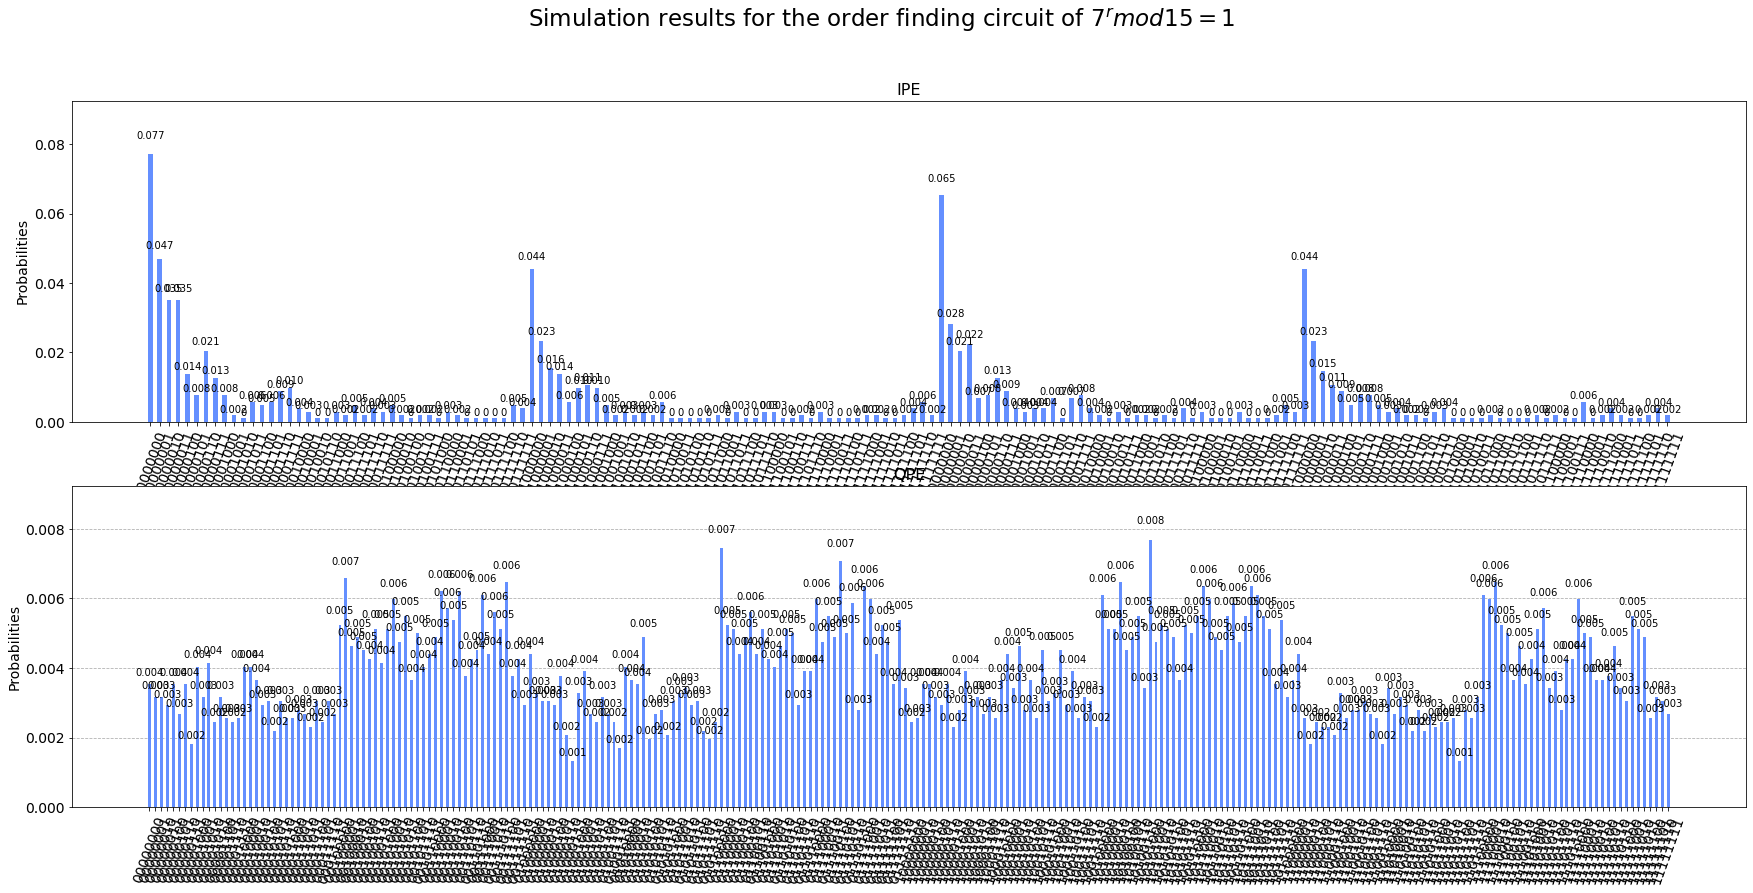

In [8]:
from qiskit.test.mock import FakeMelbourne
from qiskit.providers.aer import AerSimulator

backend = FakeMelbourne()
sim_Melbourne = AerSimulator.from_backend(backend)

shots=8192

shor_Orig_trans = transpile(shor_Orig, backend, optimization_level=3)
count_shorOrig_noise = sim_Melbourne.run(shor_Orig_trans, shots=shots).result().get_counts()
t_shor = transpile(shor_15(a, precision), sim)
qobj = assemble(t_shor)
results = sim_Melbourne.run(qobj).result()
counts = results.get_counts()
fig, ax = plt.subplots(2,1, figsize=(30,13))
fig.suptitle('Simulation results for the order finding circuit of $7^{r} mod 15 = 1$', fontsize=23)
plot_histogram(counts, ax=ax[0])
plot_histogram(count_shorOrig_noise, ax=ax[1])
ax[0].set_title('IPE', fontsize=16)
ax[1].set_title('QPE', fontsize=16)
plt.show()

In [ ]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**precision)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**precision} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

In cases 0.25 and 0.75 we get 1/4 and 3/4 so we can correctly find r = 4 and then find a factor w/p approx. 1/2


Now let's try to find the correct phase and therefore factor on singular attempts.

In [ ]:
def shor_attempt(circuit, precision):
    t_circuit = transpile(circuit, sim)
    q_obj = assemble(t_circuit, shots=1)
    result = sim.run(q_obj, memory = True).result()
    readings = result.get_memory()
    return int(readings[0],2)/(2**precision)

In [ ]:
shor_c = shor_15(7,8)
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = shor_attempt(shor_c, 8) # Phase = s/r
    print("Phase : %f" % phase)
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    print("Fraction : " + str(frac))
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True

Now let's implement modular multiplication to offer a generalized algorithm
This is an implementation of the research article found at https://arxiv.org/pdf/quant-ph/0205095.pdf

We first need the QFT

In [ ]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    #for qubit in range(n//2):
     #   qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    U = qc.to_gate()
    U.name = "QFT†"
    return U
def qft(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for j in range(n):
        for m in range(j):
            qc.cp(np.pi/float(2**(j-m)), j, m)
        qc.h(j)
    #for qubit in range(n//2):
     #   qc.swap(qubit, n-qubit-1)
    U = qc.to_gate()
    U.name = "QFT"
    return U

Then we implement the additive operation

In [ ]:
#WE NEED N+1 QUBITS ALRIGHTY?
#computes a + b where a is classical and b is quantum, with n the maximum space to prevent overflow
def adder(a, n):
    #n+1 qubits to prevent overflow
    a%=2**(n)
    qc = QuantumCircuit(n)
    m = bin(a)
    m = m[2:]
    diff = n - len(m)
    if diff  > 0:
        for _ in range(diff):
            m = "0" + m
            
    for i in range(n):
        exp = 0
        for j in range(i+1):
            exp += int(m[i-j]) * 1/2**(j)
        qc.p(+np.pi*exp, i)
    U = qc.to_gate()
    U.name = "adder %i" % a
    return U

def adder_dagger(a, n):
    #n+1 qubits to prevent overflow
    a%=2**(n)
    qc = QuantumCircuit(n)
    m = bin(a)
    m = m[2:]
    diff = n - len(m)
    if diff  > 0:
        for _ in range(diff):
            m = "0" + m
    for i in range(n):
        aux = QuantumCircuit(n)
        exp = 0
        for j in range(i+1):
            exp += int(m[i-j]) * 1/2**(j)
        qc.p(-np.pi*exp, i)
    U = qc.to_gate()
    U.name = "adder† %i" % a
    return U

This is a simplification of a regular adder gate since we don't need to add two quantum registers, but one classical register to a quantum one. We can thus group the needed rotations and perform a single operation per qubit, reducing error

In [ ]:
qc = QuantumCircuit(5)
qc.x(1)
qc.append(qft(5), range(5))
qc.append(adder(1, 5), range(5))
qc.append(qft_dagger(5), range(5))
qc.measure_all()
qc.draw()
t_qc = transpile(qc, sim)
qobj = assemble(t_qc, shots = 1024)
results = sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

Then the modular addition

In [ ]:
def mod_adder(a, N):
    n = int(ceil(np.log2(N)))
    qc = QuantumCircuit(n+4)
    qc.append(adder(a, n+1).control(2), range(n+3))
    qc.append(adder_dagger(N, n+1), range(2, 3+n))
    qc.append(qft_dagger(n+1), range(2, n+3))
    qc.cx(2, n+3)
    qc.append(qft(n+1), range(2,n+3))
    qc.append(adder(N, n+1).control(), [n+3] + [i for i in range(2,n+3)])
    qc.append(adder_dagger(a, n+1).control(2), range(n+3))
    qc.append(qft_dagger(n+1), range(2, n+3))
    qc.x(2)
    qc.cx(2, n+3)
    qc.x(2)
    qc.append(qft(n+1), range(2,n+3))
    qc.append(adder(a, n+1).control(2), range(n+3))
    U = qc.to_gate()
    U.name= "x+%i mod %i"% (a,N)
    return U

def mod_adder_dagger(a, N):
    n = int(ceil(np.log2(N)))
    qc = QuantumCircuit(n+4)
    
    qc.append(adder_dagger(a, n+1).control(2), range(n+3))
    qc.append(qft_dagger(n+1), range(2,n+3))
    qc.x(2)
    qc.cx(2, n+3)
    qc.x(2)
    qc.append(qft(n+1), range(2, n+3))
    qc.append(adder(a, n+1).control(2), range(n+3))
    qc.append(adder_dagger(N, n+1).control(), [n+3] + [i for i in range(2,n+3)])
    qc.append(qft_dagger(n+1), range(2,n+3))
    qc.cx(2, n+3)
    qc.append(qft(n+1), range(2, n+3))
    qc.append(adder(N, n+1), range(2, 3+n))
    qc.append(adder_dagger(a, n+1).control(2), range(n+3))
    
    U = qc.to_gate()
    U.name= "x+%i mod %i †"% (a,N)
    return U

This gate implements a+b-N, tests if a+b < N, in which case N is added again, thanks to the first cx gate and c adder on the ancillary qubit.
The rest of the gate is dedicated to making sure the ancillary qubit comes back to 0 at the end

Using this gate we can implement modular multiplication

In [ ]:
def c_mult_a_mod_N(a,N):
    m = int(ceil(np.log2(N)))
    qc = QuantumCircuit(2*m+3)
    qc.append(qft(m+1), range(m+1, 2*m+2))
    for i in range(m):
        qc.append(mod_adder((2**(m-i-1))*a,N), [0] + [i+1] + [j for j in range(m+1, 2*m+3)])
    qc.append(qft_dagger(m+1), range(m+1, 2*m+2))
    U = qc.to_gate()
    U.name = "CMult %i mod %i " % (a,N)
    return U

def c_mult_a_mod_N_dagger(a,N):
    m = int(ceil(np.log2(N)))
    qc = QuantumCircuit(2*m+3)
    qc.append(qft(m+1), range(m+1, 2*m+2))
    for i in range(m):
        qc.append(mod_adder_dagger((2**(i))*a,N), [0] + [m-i] + [j for j in range(m+1, 2*m+3)])
    qc.append(qft_dagger(m+1), range(m+1, 2*m+2))
    U = qc.to_gate()
    U.name = "CMult %i mod %i †" % (a,N)
    return U

This is basically bitwise (and therefore control) multiplication.

Which finally lets us implement the unitary we wanted in the first place.

In [ ]:
def c_Ua(a,N, power):
    n = int(ceil(np.log2(N)))
    qc = QuantumCircuit(2*n+3)
    qc.append(c_mult_a_mod_N(a,N), range(2*n+3))
    for i in range(n):
        qc.cswap(0, i+1, i+n+1)
    qc.append(c_mult_a_mod_N_dagger(pow(a,-1,N), N), range(2*n+3))
    U = qc.to_gate()
    U.name = "c_U %i mod %i" % (a,N)
    qc = QuantumCircuit(2*n+3)
    for _ in range(power):
        qc.append(U, range(2*n+3))
    Upow = qc.to_gate()
    Upow.name = U.name + " ^ %i" %(power)
    return Upow

This implements $|x〉|0〉 → |x〉|(ax)mod N 〉 → |(ax)mod N 〉|x〉 →
|(ax)mod N 〉|(x − a−1ax)mod N 〉 = |(ax)mod N 〉|0〉$

We can now achieve a fully generalised period finding algorithm

In [ ]:
def shor(N, a, precision):
    if gcd(N, a)!= 1:
        return gcd(N, a)
    m = ceil(np.log2(N))
    Shor = QuantumCircuit(2*m+3, precision)
    Shor.x(m)
    for i in range(precision) : 
        if i != 0:
            Shor.reset(0)
        Shor.h(0)
        Shor.append(c_Ua(a, N, 2**(precision-i-1)), range(2*m+3))
        if i != 0:
            Shor.p(-np.pi/2,0).c_if(i-1, 1)
        Shor.h(0)
        Shor.measure(0, i)
    return Shor
shor(15,7,8).draw()

In [ ]:
"""N = 15
a = 7
precision = 8
sim = Aer.get_backend('aer_simulator')
t_shor = transpile(shor(N, a, precision), sim)
qobj = assemble(t_shor)
results = sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)"""

In [ ]:
def shor_attempt(circuit, precision):
    t_circuit = transpile(circuit, sim)
    q_obj = assemble(t_circuit, shots=1)
    result = sim.run(q_obj, memory = True).result()
    readings = result.get_memory()
    return int(readings[0],2)/(2**precision)

This is obviously EXTREMELY computationally demanding for a regular computer (and requires a lot of memory aswell) so testing it takes a tremendous amount of time
So a fully generalized factorization algorithm would be as follows: 

In [ ]:
sim = Aer.get_backend('aer_simulator')
def order_finding(N, t_max):
    if N%2==0:
        return 2
    if isprime(N):
        return None
    for k in range(2, floor(np.log2(N)) + 1):
        c = pow(N, 1 / k)
        c1 = floor(c)
        if c1**k == N:
            return c1
        c2 = ceil(c)
        if c2**k == N:
            return c2
    n = floor(np.log2(N)) + 1
    for _ in range(t_max):
        a = randint(2, N - 1)
        print("\nAttempt %i: a = %i" % (_+1, a))
        phase = shor_attempt(shor(N,a,2*n), 2*n) # Phase = s/r
        print("Phase : %f" % phase)
        frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
        print("Fraction : " + str(frac))
        r = frac.denominator
        print("Result: r = %i" % r)
        if phase != 0:
            # Guesses for factors are gcd(x^{r/2} ±1 , 15)
            guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
            print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
            for guess in guesses:
                if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                    print("*** Non-trivial factor found: %i ***" % guess)
                    return guess;
    return None

In [ ]:
order_finding(21, 2)